In [2]:
import torch
import torch.nn as nn
import math

class HaceNet(nn.Module):
  def __init__(self, num_encoder_levels = 4, num_heads = 5, d_model_in_list = [32,32,(32,48),32], d_model_out_list = [10,20,(30,32),40], token_in_list = [1440, 288, (144, 216), 84], token_out_list = [144, 72, (24, 36), 84], num_metrics = 12, dropout = 0.05, batch_size = 64, token_length = 20160):
    super(HaceNet, self).__init__()

    self.num_encoder_levels = num_encoder_levels

    self.num_heads = num_heads
    self.d_model_in_list = d_model_in_list # len equal to num_encoder_layers + 1
    self.d_model_out_list = d_model_out_list
    self.num_metrics = num_metrics
    self.dropout = dropout
    self.batch_size = batch_size

    # imp: token_out_list[i] != token_in_list[i+1] because we're concattenating
    # for e.g. token_in_list = [1440, 288] and token_out_list = [144, 28]

    # similarly, d_model_out_list[i] != d_model_in_list[i + 1] because input layers might be projecting
    # for e.g.  d_model_in_list = [32, 48], d_model_out_list = [16, 12]
    # in the above case

    self.token_in_list = token_in_list  # len equal to num_encoder_layers
    self.token_out_list = token_out_list # len equal to num_encoder_layers

    # input embedding layer
    self.input_encodings = nn.ModuleList([InputEncoding(d_model_in = self.num_metrics, d_model_out = self.d_model_in_list[0])])
   # print('finished first input encoding layer')
    for dmo_index in range(len(self.d_model_out_list) - 1):
      #print(dmo_index)

   #   print(f"starting dmo_index: {dmo_index}")
      if (dmo_index == 1):
        for sub_index in range(2):
  #        print(f"dmo_index:{dmo_index}, sub_index:{sub_index}, d_model_in:{self.d_model_out_list[dmo_index]}, d_model_out:{self.d_model_in_list[dmo_index + 1][sub_index]}")
          self.input_encodings.append(InputEncoding(d_model_in = self.d_model_out_list[dmo_index], d_model_out = self.d_model_in_list[dmo_index + 1][sub_index]))
        continue

      if (dmo_index == 2):
        for sub_index in range(2):
   #       print(f"d_model_out_list[dmo_index][sub_index] = {self.d_model_out_list[dmo_index][sub_index]}")
   #       print(f"d_model_in_list[dmo_index + 1][sub_index] = {self.d_model_in_list[dmo_index + 1]}")
          self.input_encodings.append(InputEncoding(d_model_in = self.d_model_out_list[dmo_index][sub_index], d_model_out = self.d_model_in_list[dmo_index + 1]))
        continue

  #    print(f"dmo_index: {dmo_index} & d_model_in : {self.d_model_out_list[dmo_index]} & d_model_out : {self.d_model_in_list[dmo_index+1]}")
      self.input_encodings.append(InputEncoding(d_model_in = self.d_model_out_list[dmo_index], d_model_out = self.d_model_in_list[dmo_index + 1]))
  #    print()

  #  print(f"number of input encodings blocks: {len(self.input_encodings)}")
  #  print(self.input_encodings)

  #  print()
  #  print('finished input encodings')

    # position encoding layer
    self.positional_encodings = nn.ModuleList()
    for k in range(len(token_in_list)):
      if (k == 2):
        for j in range(2):
          self.positional_encodings.append(PositionalEncoding(d_model = self.d_model_in_list[k][j], max_len = self.token_in_list[k][j]))
        continue

      self.positional_encodings.append(PositionalEncoding(d_model = self.d_model_in_list[k], max_len = token_in_list[k]))

#    print("finished position encoding")
    # creating segment encodings
    self.segment_encodings_lvl_1 = nn.ParameterList()
    for segment in range(2):
      self.segment_encodings_lvl_1.append(nn.Parameter(torch.randn(1, self.d_model_in_list[1])))

 #   print("finished segment encodings lvl 1")

    self.segment_encodings_lvl_2_s1 = nn.ParameterList()
    self.segment_encodings_lvl_2_s2 = nn.ParameterList()

    for segment in range(2):
      self.segment_encodings_lvl_2_s1.append(nn.Parameter(torch.randn(1, self.d_model_in_list[2][0])))
    for segment in range(3):
      self.segment_encodings_lvl_2_s2.append(nn.Parameter(torch.randn(1, self.d_model_in_list[2][1])))

 #   print("finished segment ecndoings lvl 2")

    self.segment_encodings_lvl_3 = nn.ParameterList()
    for segment in range(3):
      self.segment_encodings_lvl_3.append(nn.Parameter(torch.randn(1, self.d_model_in_list[3])))


 #   print("finished segment encodings")

    self.hace_layer_level = [0,1,2,2,3]
    self.hace_blocks = nn.ModuleList()

#d_model_in_list = [32,32,(32,32),32], d_model_out_list = [32,32,(32,32),32],
#token_in_list = [1440, 288, (144, 216), 84], token_out_list = [144, 72, (28, 28), 84]

    for i in range(self.num_encoder_levels):
      if (i == 2):
        for j in range(2):
          self.hace_blocks.append(HACEBlock(num_tokens_in = token_in_list[i][j],
                                  num_tokens_out = token_out_list[i][j],
                                  d_model_in = d_model_in_list[i][j],
                                  d_model_out = d_model_out_list[i][j],
                                  num_heads = self.num_heads))

        continue
      self.hace_blocks.append(HACEBlock(num_tokens_in = token_in_list[i],
                                      num_tokens_out = token_out_list[i],
                                      d_model_in = d_model_in_list[i],
                                      d_model_out = d_model_out_list[i],
                                       num_heads = self.num_heads))

 #   self.hace_blocks = nn.ModuleList([HACEBlock(num_tokens_in = self.token_in_list[i],
  #                                              num_tokens_out = self.token_out_list[i],
   #                                             d_model_in = self.d_model_list[i],
    #                                            d_model_out = self.d_model_out_list[i]) for i in range(self.num_encoders)])

    self.postprocessing_linear_1 = nn.Linear(in_features = d_model_out_list[(self.num_encoder_levels) - 1], out_features = 64)
    self.postprocessing_linear_2 = nn.Linear(in_features = 64, out_features = 42)
    #adding
    self.postprocessing_linear_2_1 = nn.Linear(in_features = 42, out_features = 16)
    self.postprocessing_linear_3 = nn.Linear(in_features = 16, out_features = 1)

    self.pre_output_linear = nn.Linear(in_features = self.token_out_list[-1], out_features = 1)
    self.output_sigmoid = nn.Sigmoid()

    print(f"input encodings length: {len(self.input_encodings)}")
    print(f"position encodings length: {len(self.positional_encodings)}")
    print(f"num of hace blocks: {len(self.hace_blocks)}")


  def forward(self, X):

  #  print()
  #  print("Processing lvl 1: ")
    L1 = X
    # get input embeddings and position encodings
   # print(self.input_encodings[0])
    for day_matrix_idx in range(14):
     # print(f"starting lvl 1 input encoding work for index {day_matrix_idx}")
      L1[day_matrix_idx] = (self.input_encodings[0])(L1[day_matrix_idx])
    #  print(f"lvl 1 input encoding working for index {day_matrix_idx}")
      L1[day_matrix_idx] = (self.positional_encodings[0])(L1[day_matrix_idx])
      L1[day_matrix_idx] = (self.hace_blocks[0])(L1[day_matrix_idx])

  #  print("Done Processing lvl 1: ")

   # print(L1[0].shape)
   # print()
  #  print("Processing lvl 2: ")
    L2 = []
    L2_idx = 0
    segment_l1_length = 144
    for day_matrix_idx in range(0,14,2):
      L2.append(torch.cat((L1[day_matrix_idx], L1[day_matrix_idx + 1]), dim = 1))
   #   print(f"{day_matrix_idx}: {L2[L2_idx].shape}")
      #input encodings
 #     print(self.input_encodings[1])
      L2[L2_idx] = (self.input_encodings[1])(L2[L2_idx])
     # print(f"lvl2 input encodings done for idx {day_matrix_idx}")
   #   print(f"new shape for {day_matrix_idx}: {L2[L2_idx].shape}")
      #segment encodings
      (L2[L2_idx])[:, :segment_l1_length, :] += self.segment_encodings_lvl_1[0]
      (L2[L2_idx])[:, segment_l1_length:, :] += self.segment_encodings_lvl_1[1]
      #position encodings
      L2[L2_idx] = (self.positional_encodings[1])(L2[L2_idx])
      L2[L2_idx] = (self.hace_blocks[1])(L2[L2_idx])
      L2_idx += 1

 #   print("Done Processing lvl 2: ")
  #  print("Processing lvl 3: ")

    L3 = []
    segment_l3_s1_length = 72
    segment_l3_s2_length = 72

    L3.append(torch.cat((L2[0], L2[1]), dim = 1))
  #  print(self.input_encodings[2])
  #  print(L3[0].shape)
    L3[0] = (self.input_encodings[2])(L3[0])
    (L3[0])[:, :segment_l3_s1_length, :] += self.segment_encodings_lvl_2_s1[0]
    (L3[0])[:, segment_l3_s1_length:, :] += self.segment_encodings_lvl_2_s1[1]
    L3[0] = (self.positional_encodings[2])(L3[0])
    L3[0] = (self.hace_blocks[2])(L3[0])

   # print(f"{L3[0].shape}")
  #  print("Done with lvl3 first block")

    L3.append(torch.cat(([L2[2], L2[3], L2[4]]), dim = 1))
    #print(self.input_encodings[3])
  #  print(L3[1].shape)
    L3[1] = (self.input_encodings[3])(L3[1])
  #  print(f"After encoding: {L3[1].shape}")
    (L3[1])[:, :segment_l3_s2_length, :] += self.segment_encodings_lvl_2_s2[0]
    (L3[1])[:, segment_l3_s2_length:2*segment_l3_s2_length, :] += self.segment_encodings_lvl_2_s2[1]
    (L3[1])[:, 2*segment_l3_s2_length:, :] += self.segment_encodings_lvl_2_s2[2]
    L3[1] = (self.positional_encodings[3])(L3[1])
   # print(f"After positional encoding: {L3[1].shape}")
   # print(self.hace_blocks[3])
    L3[1] = (self.hace_blocks[3])(L3[1])
 #   print(f"After HACE block: {L3[1].shape}")

    L3.append(torch.cat((L2[5], L2[6]), dim = 1))
    L3[2] = (self.input_encodings[2])(L3[2])
    (L3[2])[:, :segment_l3_s1_length, :] += self.segment_encodings_lvl_2_s1[0]
    (L3[2])[:, segment_l3_s1_length:, :] += self.segment_encodings_lvl_2_s1[1]
    L3[2] = (self.positional_encodings[2])(L3[2])
    L3[2] = (self.hace_blocks[2](L3[2]))

  #  print(f"L3 shape: {len(L3)}")

 #   print("Done Processing lvl 3: ")
  #  print("Processing lvl 4: ")

    L4_pre = L3
    segment_l4_length = 28

  #  print(f"L4_pre shape: {len(L4_pre)}")
   # print(L4_pre[0].shape)
   # print(L4_pre[1].shape)
   # print(L4_pre[2].shape)

   # print(self.input_encodings[4])
   # print(self.input_encodings[5])

    L4_pre[0] = (self.input_encodings[4])(L4_pre[0])
    L4_pre[1] = (self.input_encodings[5])(L4_pre[1])
    L4_pre[2] = (self.input_encodings[4])(L4_pre[2])

    L4 = [torch.cat((L4_pre[0], L4_pre[1], L4_pre[2]), dim = 1)]


    # project L3[0] and L3[2] with input_encodings[4]
    # project L3[1] with input_encodings[5]
   # L4[0] = (self.input_encodings[4])(L4[0])
    (L4[0])[:, :segment_l4_length, :] += self.segment_encodings_lvl_3[0]
    (L4[0])[:, segment_l4_length:2*segment_l4_length, :] += self.segment_encodings_lvl_3[1]
    (L4[0])[:, 2*segment_l4_length:, :] += self.segment_encodings_lvl_3[2]
    L4[0] = (self.positional_encodings[4])(L4[0])
    L4[0] = (self.hace_blocks[4])(L4[0])
  #  print("Done Processing lvl 4 ")


 #   print(L4[0][0])
  #  print(L4[0][1])
   # print(L4[0][2])

  #  print()

    postprocessing_1_output = self.postprocessing_linear_1(L4[0])
    postprocessing_2_output = self.postprocessing_linear_2(postprocessing_1_output)
    postprocessing_2_1_output = self.postprocessing_linear_2_1(postprocessing_2_output)
    postprocessing_3_output = self.postprocessing_linear_3(postprocessing_2_1_output)
    postprocessing_squeezed = postprocessing_3_output.squeeze(-1)
  #  print("Done Postprocessing")


    pre_sigmoid_output = self.pre_output_linear(postprocessing_squeezed)
 #   print("Done pre sigmoid")

    output_layer = self.output_sigmoid(pre_sigmoid_output)
 #   print("Done output sigmoid")

 #   print(f"Probability of disorder: {output_layer}")
    return output_layer
   # return output_layer


class InputEncoding(nn.Module):
  def __init__(self, d_model_in, d_model_out):
    super(InputEncoding, self).__init__()

    self.d_model_in = d_model_in
    self.d_model_out = d_model_out

    self.linear_embedding_layer = nn.Sequential(
        nn.Linear(in_features = self.d_model_in, out_features = self.d_model_out * 2),
        nn.ReLU(),
        nn.Linear(in_features = self.d_model_out * 2, out_features = self.d_model_out),
    )

  def forward(self, x):
    embedding = self.linear_embedding_layer(x)
    return embedding


class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len = 10000, log_factor = 10000):
    super(PositionalEncoding, self).__init__()

    pe = torch.zeros(max_len, d_model)

    position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1) # get position indices
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000) / d_model)) # get positional coefficients

    pe[:,0::2] = torch.sin(position * div_term) # set even indices of embeddings
    pe[:,1::2] = torch.cos(position * div_term) # set odd indices of embeddings
    pe = pe.unsqueeze(0) # broadcast to account for batch size

    self.register_buffer('pe', pe)

  def forward(self, x):
    x += self.pe[:,:x.size(1), :] # adds positional encodings to input embeddings
    return x

class HACEBlock(nn.Module):
  def __init__(self, num_tokens_in, num_tokens_out, d_model_in, d_model_out, num_heads):
    super(HACEBlock, self).__init__()

    self.num_tokens_in = num_tokens_in
    self.num_tokens_out = num_tokens_out
    self.vertical = num_tokens_in // num_tokens_out

    self.d_model_in = d_model_in
    self.d_model_out = d_model_out

    #print(f"HACEBlock, d_model_in: {d_model_in}")

    self.num_heads = num_heads
    self.mha = MultiHeadAttention(d_model_in, self.num_heads)
    self.norm1 = nn.LayerNorm(d_model_in)

    self.ffn = nn.Sequential(
        nn.Linear(in_features = d_model_in, out_features = 4 * d_model_in),
        nn.ReLU(),
        nn.Linear(in_features = 4 * d_model_in, out_features = d_model_in)
    )
    self.norm2 = nn.LayerNorm(d_model_in)
    self.conv_layer = ConvolutionLayer(d_model = self.d_model_in, vertical = self.vertical, num_features = self.d_model_out)
    self.norm3 = nn.LayerNorm(self.d_model_out)


  def forward(self, x):
    mha_out = self.mha(x)
    residual_addition_attention = x + mha_out
    norm_attention = self.norm1(residual_addition_attention)

    ffn_output = self.ffn(norm_attention)
    residual_addition_ffn = norm_attention + ffn_output
    encoder_output = self.norm2(residual_addition_ffn)

    condensed_encodings = self.conv_layer(encoder_output)
    normalized_condensed_encodings = self.norm3(condensed_encodings)

    return normalized_condensed_encodings

class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()

    self.d_model = d_model
    self.num_heads = num_heads
    try:
      self.head_dim = d_model // num_heads # get dimension for each head
    except:
      print(d_model)

    self.query_heads = nn.ModuleList([nn.Linear(self.d_model, self.head_dim) for head in range(num_heads)])
    self.key_heads = nn.ModuleList([nn.Linear(self.d_model, self.head_dim) for head in range(num_heads)])
    self.value_heads = nn.ModuleList([nn.Linear(self.d_model, self.head_dim) for head in range(num_heads)])

    self.w_matrix = nn.Linear(self.d_model, self.d_model)

  def forward(self, input_matrix):

    batch_size = input_matrix.size(0)
    num_tokens = input_matrix.size(1)

    query_matrices = [query_matrix_weights(input_matrix) for query_matrix_weights in self.query_heads]
    key_matrices = [key_matrix_weights(input_matrix) for key_matrix_weights in self.key_heads]
    value_matrices = [value_matrix_weights(input_matrix) for value_matrix_weights in self.value_heads]

    z_matrices = []

    for query_matrix, key_matrix, value_matrix in zip(query_matrices, key_matrices, value_matrices):

       score_matrix = torch.matmul(query_matrix, key_matrix.transpose(-2,-1)) / math.sqrt(self.head_dim)
       attention_weights = torch.softmax(score_matrix, dim = -1)
       attention_matrix = torch.matmul(attention_weights, value_matrix)

       z_matrices.append(attention_matrix)

    multihead_z_concat = torch.cat(z_matrices, dim = -1)
   # print(multihead_z_concat.shape)
    encoder_attention_output = self.w_matrix(multihead_z_concat)

    return encoder_attention_output

class ConvolutionLayer(nn.Module):
  def __init__(self, d_model, vertical, num_features):
    super(ConvolutionLayer, self).__init__()

    self.num_features = num_features
    self.kernel_size = (vertical, d_model)
  #  print(f"kernel size: {self.kernel_size}")
    self.stride = (vertical, 1)

    self.conv_layer = nn.Conv2d(in_channels = 1, out_channels = self.num_features, kernel_size = self.kernel_size, stride = self.stride)

  def forward(self, x):

    batch_size = x.size(0)
    num_tokens = x.size(1)

  #  print(f"before 4d transform, x shape: {x.shape}")
    x = x.unsqueeze(0).permute(1,0,2,3)
  #  print(f"after 4d transform, x shape: {x.shape}")

    convolution_output = self.conv_layer(x)
  #  print(f"convolution output shape: {convolution_output.shape}")
    n_condensed_tokens = convolution_output.size(2)

    condensed_encoding = (convolution_output.permute(0,2,1,3)).view(batch_size, n_condensed_tokens, self.num_features)
  #  print(f"condensed_encoding expected shape: {(batch_size, n_condensed_tokens, self.num_features)}, actual shape : {condensed_encoding.shape}")

    return condensed_encoding

In [3]:
import matplotlib.pyplot as plt

In [4]:
model = torch.load("/content/model_78_68.pth", map_location = torch.device('cpu'))

In [5]:
model = model.module
print(isinstance(model, nn.DataParallel))

False


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Input Encodings Visualizations

In [14]:
def visualize_input_encoding_weights(model, index, linear_index, to_return = False):

  ie_weights = model.input_encodings[index].linear_embedding_layer[linear_index].weight.data.to("cpu").numpy()
  plt.figure(figsize=(12, 6))
  plt.imshow(ie_weights, cmap='coolwarm', aspect='auto')
  plt.colorbar()
  plt.title(f'Weights Visualization of the Linear Layer {linear_index} in input_encoding[{index}]')
  plt.xlabel('Input Feature index')
  plt.ylabel('Output neuron index')
  plt.show()

  if (to_return):
    return ie_weights

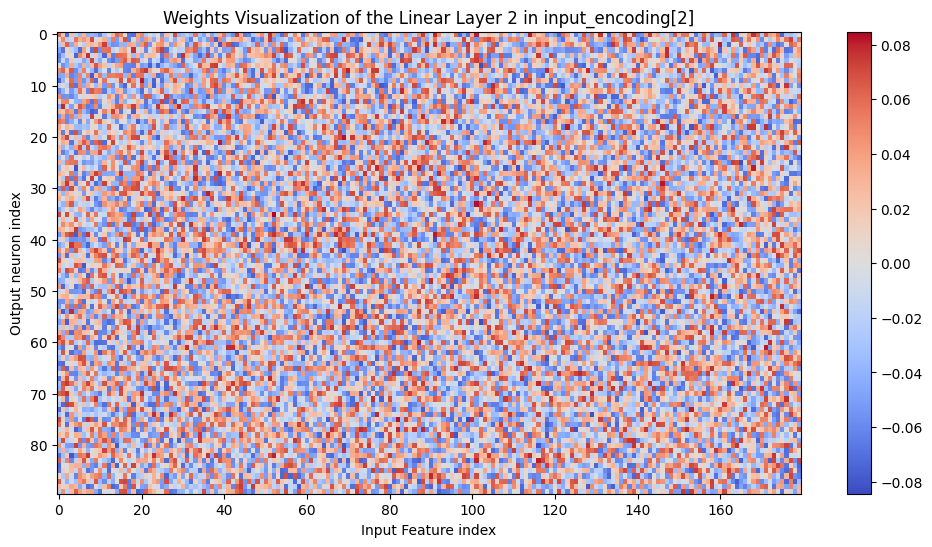

In [46]:
visualize_input_encoding_weights(model, 2, 2)

# Query, Key, Value Weights Visualization

In [25]:
def visualize_attention_weights(model, hace_index, indicator = 'Q', to_return = False):

  weights_list = []
  if (indicator == 'Q'):
    for head_index in range(model.hace_blocks[hace_index].mha.num_heads):
      weights_list.append(model.hace_blocks[hace_index].mha.query_heads[head_index].weight.data.to("cpu").numpy())
  if (indicator == 'K'):
    for head_index in range(model.hace_blocks[hace_index].mha.num_heads):
      weights_list.append(model.hace_blocks[hace_index].mha.key_heads[head_index].weight.data.to("cpu").numpy())
  if (indicator == 'V'):
    for head_index in range(model.hace_blocks[hace_index].mha.num_heads):
      weights_list.append(model.hace_blocks[hace_index].mha.value_heads[head_index].weight.data.to("cpu").numpy())

  num_heads = model.hace_blocks[hace_index].mha.num_heads

  # Plotting
  fig, axes = plt.subplots(2, (num_heads // 2), figsize=(18, 12))  # 2 rows, 3 columns
  axes = axes.flatten()

  title_mapping = {"Q":"Query", "K":"Key", "V":"Value"}

  for i, weights in enumerate(weights_list):
    ax = axes[i]
    cax = ax.imshow(weights, cmap='coolwarm', aspect='auto')
    ax.set_title(f'{title_mapping[indicator]} Weights Head {i}')
    ax.set_xlabel('Input Feature Index')
    ax.set_ylabel(f'{title_mapping[indicator]} Feature Index')
    fig.colorbar(cax, ax=ax)

  plt.tight_layout()
  plt.show()

  if (to_return):
    return weights_list

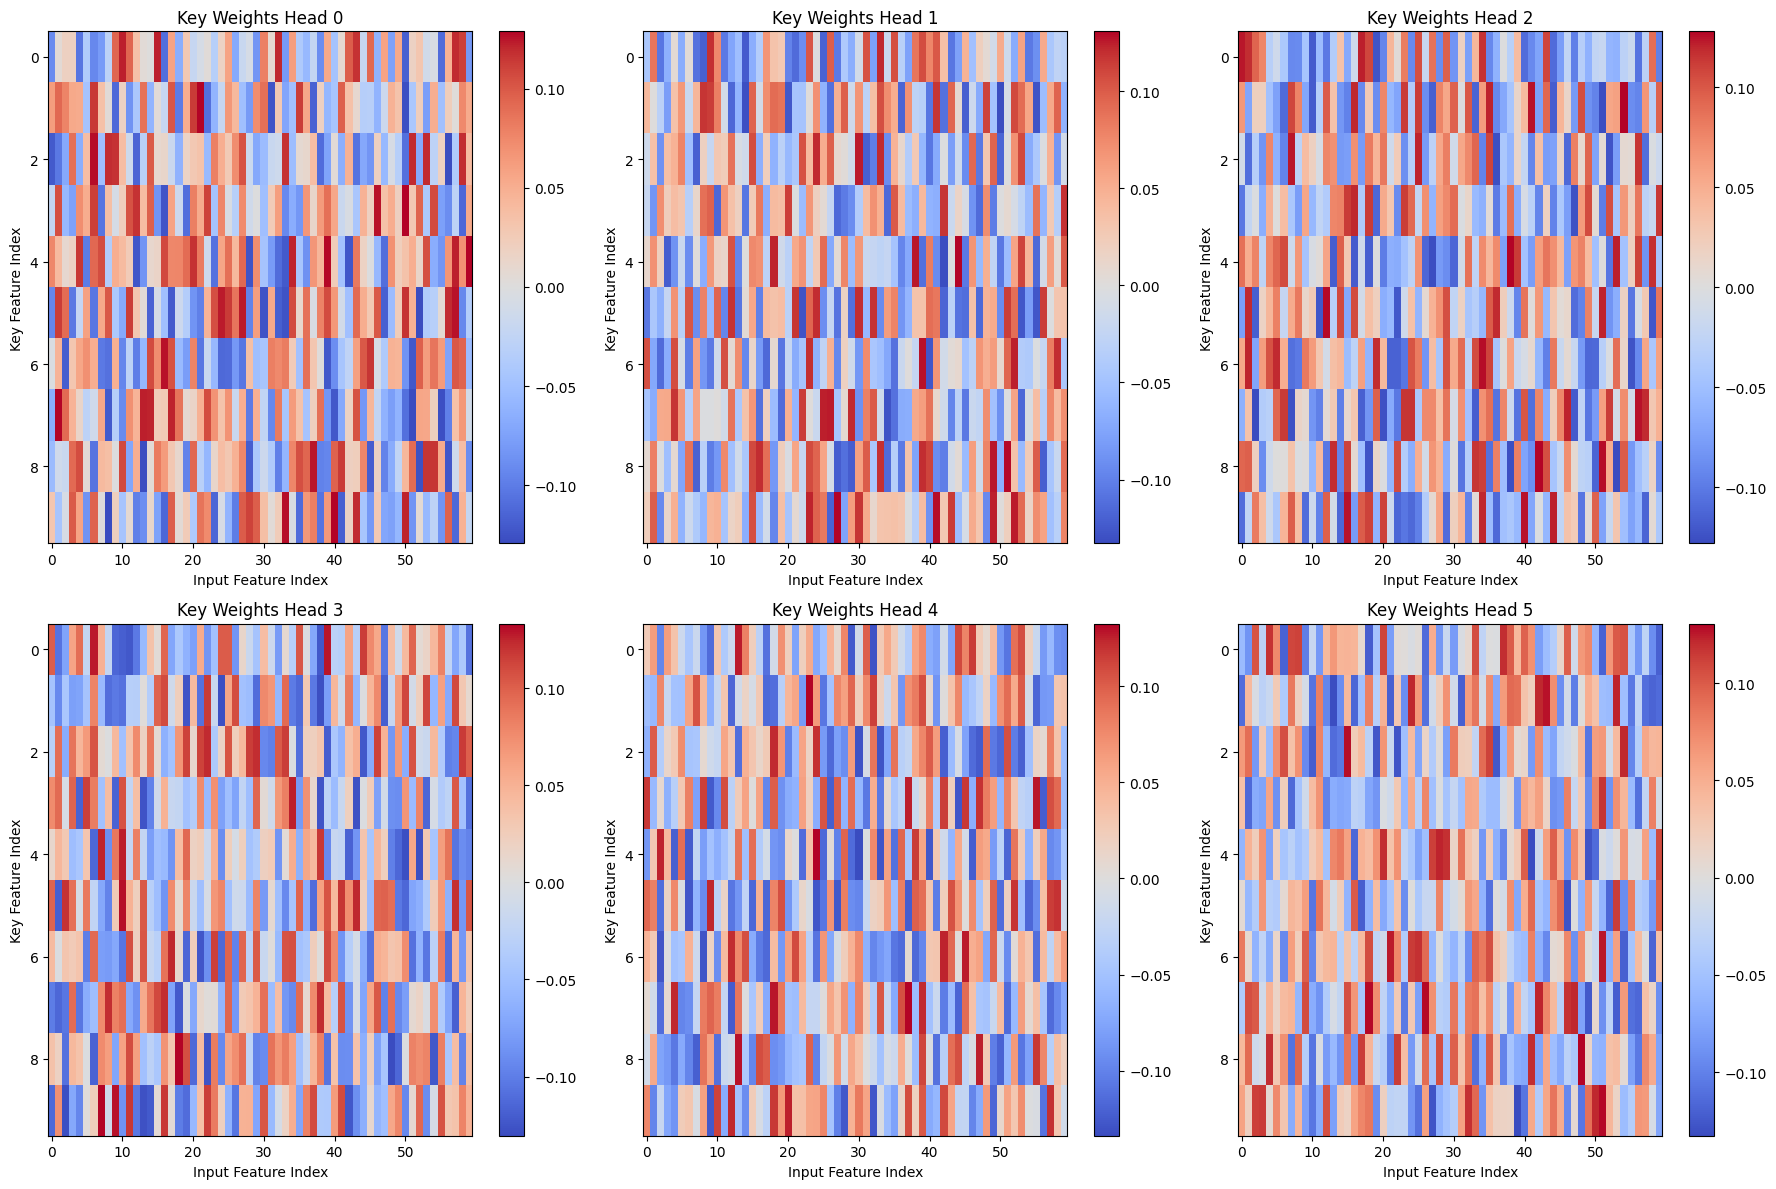

In [26]:
visualize_attention_weights(model, 0, "V")

# Linear Post Processing Visualization


In [33]:
def visualize_postprocessing_linear_weights(model, id, to_return = False):

  weights = eval("model.postprocessing_linear_" + id + ".weight.data").to("cpu").numpy()

  plt.figure(figsize=(12, 6))
  plt.imshow(weights, cmap='coolwarm', aspect='auto')
  plt.colorbar()
  plt.title('Weights Visualization of the Postprocessing Linear ' + id + ' layer')
  plt.xlabel('Input Feature Index')
  plt.ylabel('Neuron Index')
  plt.show()

  if (to_return):
    return weights

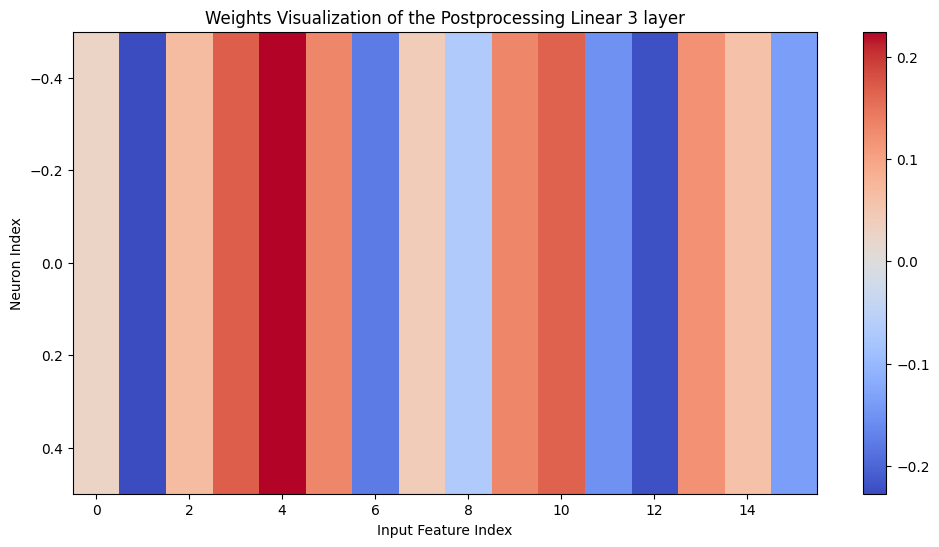

In [34]:
visualize_postprocessing_linear_weights(model, "2_1")

In [38]:
HB0_conv2d_kernel_weights = model.hace_blocks[0].conv_layer.conv_layer.weight.data.to("cpu").numpy()
#HB0_conv2d_kernel_weights

# Convolutional Kernel Visualization

In [39]:
def visualize_conv2d_kernel(model, hace_index, kernel_index, to_return = False):

  kernel_weights = model.hace_blocks[hace_index].conv_layer.conv_layer.weight.data.to("cpu").numpy()

  def visualize_single_kernel(kernels, kernel_index):
    num_kernels, in_channels, kernel_height, kernel_width = kernels.shape

    if kernel_index >= num_kernels or kernel_index < 0:
        raise ValueError(f"kernel_index should be in the range [0, {num_kernels-1}]")

    # Since there's only one input channel, we always use the first (and only) channel
    kernel = kernels[kernel_index, 0, :, :]

    plt.figure(figsize=(10, 2))
    plt.imshow(kernel, cmap='coolwarm')
    plt.title(f'Kernel {kernel_index}')
    plt.colorbar()
    plt.axis('off')
    plt.show()

  visualize_single_kernel(kernel_weights, kernel_index)

  if (to_return):
    return kernel_weights


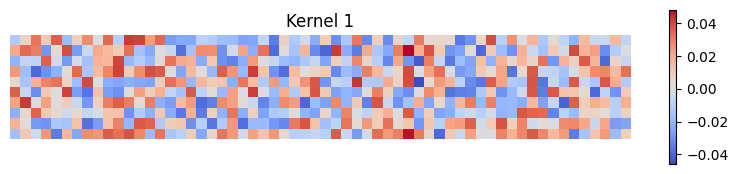

In [41]:
visualize_conv2d_kernel(model, 0, 0-5)

In [ ]:
1440 * 12. 6 kernels each of the size (144 * 12) = 10 * 6

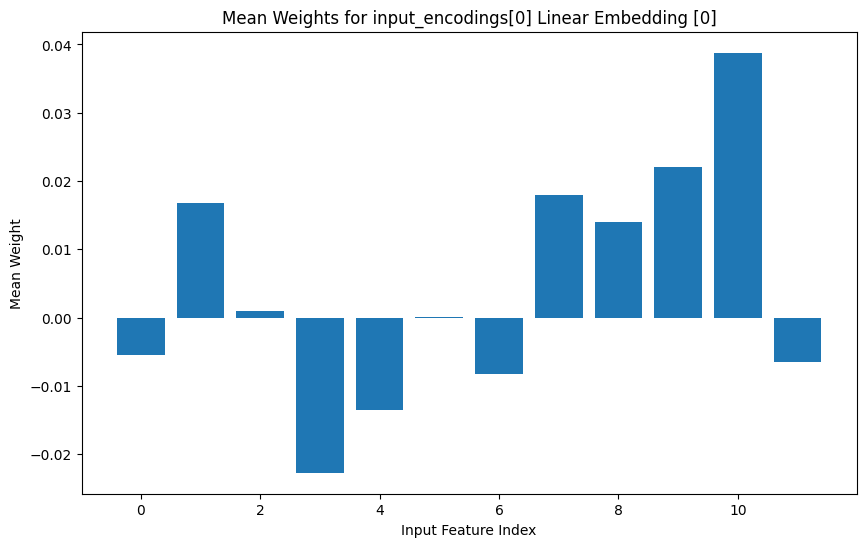

In [42]:
plot_mean_weights(IE0_LE_0_weights, "input_encodings[0] Linear Embedding [0]")

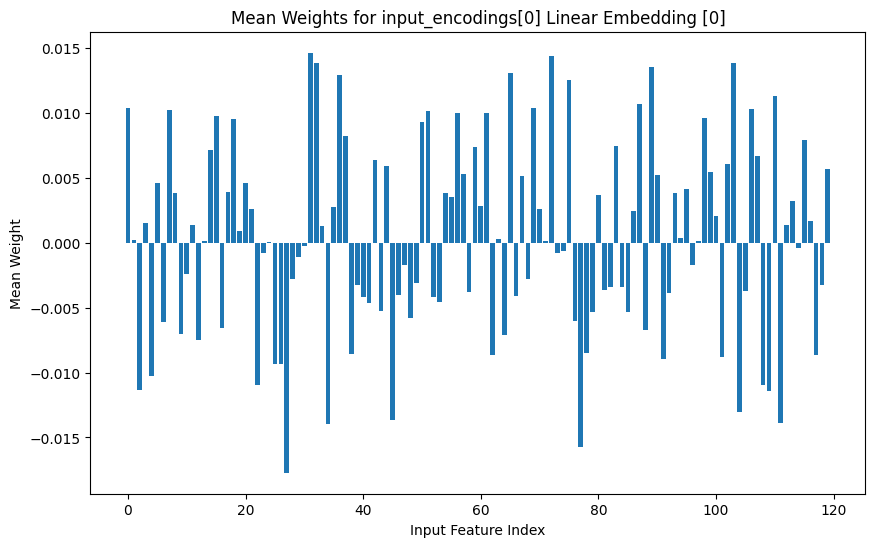

In [48]:
plot_mean_weights(IE0_LE_2_weights, "input_encodings[0] Linear Embedding [0]")

In [32]:
def plot_boxplot_weights(weight_matrix, layer_name):
    """
    Plot a box plot of the weights for each input feature (dim_in) across all neurons (dim_out).

    Args:
    - weight_matrix (numpy.ndarray): Weight matrix of shape (dim_out, dim_in).
    - layer_name (str): Name of the layer for labeling the plot.
    """
    # Plot the box plot of the weights
    plt.figure(figsize=(12, 8))
    plt.boxplot(weight_matrix, vert=True, patch_artist=True)
    plt.xlabel('Input Feature Index')
    plt.ylabel('Weight')
    plt.title(f'Box Plot of Weights for {layer_name}')
    plt.show()


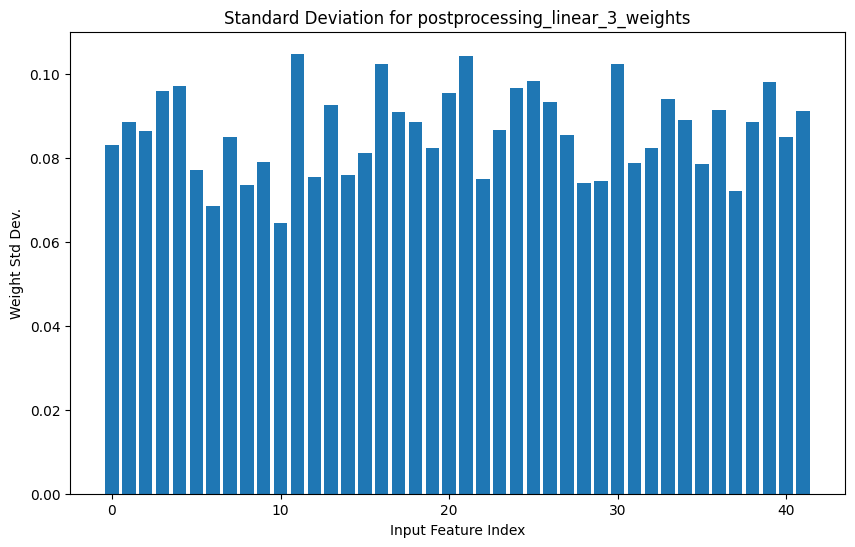

In [47]:
plot_std_weights(postprocessing_linear_2_1_weights, "postprocessing_linear_3_weights")
#

In [50]:
5

5